In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import IPython
import torch as ch
from torch import Tensor
from torch.distributions import Uniform, Gumbel
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LogisticRegression

from delphi.stats.logistic_regression import TruncatedLogisticRegression
from delphi import oracle
from delphi import train 
import delphi.utils.constants as consts
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Helpers

In [2]:
# EXP_NAME = 'TruncatedLogisticRegressionWeightDecay'
# EXP_NAME ='TruncatedLogisticRegression1e-1'
# EXP_NAME = 'IdentityTest'
EXP_NAME = 'L2LogitBall'
STORE_PATH = '/home/pstefanou/LogisticRegression/' + EXP_NAME

## Default Experiment Parameters

In [3]:
class Logit_Ball: 
    """
    Truncation based off of norm of logits. Logt norm needs to be smaller than input bound.
    In other words, retain the input that the classifier is less certain on. Smaller 
    unnormalized log probabilities implies uncertainty in classification.
    """
    def __init__(self, bound): 
        self.bound = bound
        
    def __call__(self, x): 
        return (x.norm(dim=-1) <= self.bound)
    
class Logit_Ball_Complement: 
    
    """
    Truncation based off of complement norm of logits. Logit norm needs to be greater than input bound.
    In other words, retain the inputs that the classifier is more certain on. Larger 
    unnormalized log probabilities implies more certraining in classification.
    """
    def __inti__(self, bound): 
        self.bound = bound
        
    def __call__(self, x): 
        return (x.norm(dim=-1) >= self.bound)

In [4]:
# procedure hyperparameters
args = Parameters({ 
    'workers': 8, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'samples': 100000, 
    'in_features': 2, 
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': True, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'step_lr': 1, 
    'step_lr_gamma': 1.0,
    'var': True,
    'momentum': 0.0, 
    'weight_decay': 0.0, 
    'lower': -1, 
    'upper': 1,
#     'custom_lr_multiplier': consts.COSINE, 
    'multi': 'multinomial',
    'out_features': 2, 
    'alpha_thresh': .3, 
    'steps': 5000, 
    'log_iters': 1,
    'accuracy': True,
    'tol': 1e-100, 
    'norm': False, 
    'bound': 1.0
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
    print("using cuda...")
else: 
    args.__setattr__('device', 'cpu')

using cuda...


In [8]:
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(args.lower, args.upper) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.alpha_thresh:
            # generate ground-truth from uniform distribution
            ground_truth = ch.nn.Linear(in_features=args.in_features, out_features=args.out_features, bias=args.bias)
            ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([args.out_features, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([args.out_features,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.in_features]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(noised).float()
            indices = trunc.nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices].cpu(), y[indices].cpu()
            alpha = x_trunc.size(0) / X.size(0)
            
        # split ds into training and validation data sets - 80% training, 20% validation
        train_length = int(len(x_trunc)*.8)
        val_length = len(x_trunc) - train_length
        train_x, train_y = x_trunc[:train_length], y_trunc[:train_length]
        val_x, val_y = x_trunc[train_length:], y_trunc[train_length:]

        # test dataset
        x_test = X[~indices].cpu()
        y_test = y[~indices].cpu()
            
    return ground_truth, ((train_x, train_y), (val_x, val_y)), (x_test, y_test), alpha

In [6]:
class epoch_hook: 
    """
    End epoch hook for training procedure. 
    """
    def __init__(self, store, table_name=None, ground_truth=None): 
        # model ground truth
        self.gt_params = None
        if ground_truth is not None: 
            self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
        self.store = store
        
        # check for different table name
        self.table_name = table_name
        if not table_name: 
            self.table_name = 'ground_truth_table'
        self.store.add_table(self.table_name, { 
            'cos_sim': float, 
            'l2': float,
            'epoch': int,
        })
        
    # set ground_truth for exp
    def set_ground_truth(self, ground_truth): 
        self.gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)

    def __call__(self, model, epoch): 
        # current model parameters
        trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1).cpu()
        # cosine similarity and l2 distance
        cos_sim = float(ch.nn.functional.cosine_similarity(self.gt_params, trunc_params, dim=0))
        l2_dist = float(ch.nn.MSELoss()(self.gt_params, trunc_params))

        ground_truth_info = { 
            'epoch': epoch + 1, 
            'cos_sim': cos_sim, 
            'l2': l2_dist,
        }

        self.store[self.table_name].append_row(ground_truth_info)

# Experiment

In [9]:
# establish oracle 
args.__setattr__('phi', Logit_Ball(1.0))
# args.__setattr__('phi', oracle.Identity())

# create store
store = Store(STORE_PATH)

store.add_table('results', { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
})

# epoch hooks
delphi_epoch_hook = epoch_hook(store, table_name='delphi_truth_table')
standard_epoch_hook = epoch_hook(store, table_name='standard_truth_table')

# generate ground-truth and data
ground_truth, data, test_data, alpha = gen_data()
delphi_epoch_hook.set_ground_truth(ground_truth)
standard_epoch_hook.set_ground_truth(ground_truth)

# set initial manual seed, so that procedures start from same point
ch.manual_seed(0)
# truncated logistic regression
args.__setattr__('epoch_hook', delphi_epoch_hook)
log_reg = TruncatedLogisticRegression(args.phi, alpha, args, device=args.device, multi_class=args.multi, store=store, table='delphi_logs')
results = log_reg.fit(data[0][0], data[0][1])
w, w0 = results.weight.cpu(), results.bias.cpu()

# set initial manual seed, so that procedures start from same point
ch.manual_seed(0)
# new classifier models at the beginning of each trial
args.__setattr__('epoch_hook', standard_epoch_hook)
standard_log_reg = ch.nn.Linear(in_features=args.in_features, out_features=args.out_features, bias=args.bias)
train_loader = DataLoader(TensorDataset(data[0][0], data[0][1]), num_workers=args.workers, batch_size=args.batch_size)
val_loader = DataLoader(TensorDataset(data[1][0], data[1][1]), num_workers=args.workers, batch_size=args.batch_size)
# naive ce loss
args.__setattr__('custom_criterion', ch.nn.CrossEntropyLoss()) # default ce loss
train.train_model(args, standard_log_reg, (train_loader, val_loader), store=store, 
            table='standard_logs')

# parameter estimates 
real_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(0).cpu()
mle_params = ch.cat([standard_log_reg.weight.flatten(), standard_log_reg.bias]).unsqueeze(0).cpu()
delphi_params = ch.cat([w.flatten(), w0]).unsqueeze(0).cpu()

store['results'].append_row({ 
    'delphi_cos': F.cosine_similarity(delphi_params, Tensor(real_params)),
    'mle_cos': F.cosine_similarity(mle_params, real_params),
    'alpha': float(args.alpha),
})

IPython.display.clear_output(wait=False)

# close current store
store.close()

Logging in: /home/pstefanou/LogisticRegression/L2LogitBall/74152d26-6bfe-412d-92ac-63cebc8a4836


TypeError: can't pickle KeyedRef objects

# Training Curves

100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


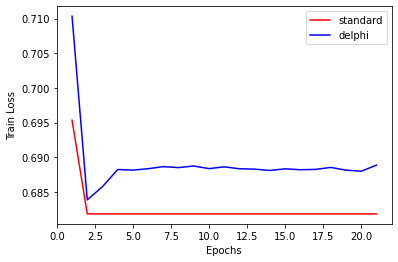

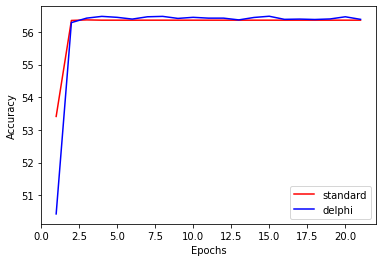

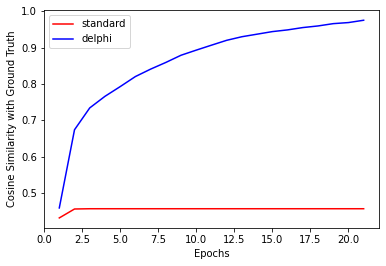

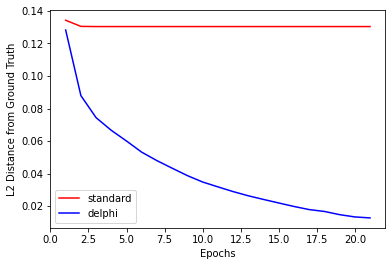

In [27]:
reader = CollectionReader(STORE_PATH)
standard_logs = reader.df('standard_logs')
delphi_logs = reader.df('delphi_logs')
standard_truth = reader.df('standard_truth_table')
delphi_truth = reader.df('delphi_truth_table')
results = reader.df('results')
reader.close() # close reader

# loss curve 
sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='standard', color='red')
ax = sns.lineplot(data=delphi_logs, x='epoch', y='train_loss', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='Train Loss')
plt.show()

# acc curve 
sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='standard', color='red')
ax = sns.lineplot(data=delphi_logs, x='epoch', y='train_prec1', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='Accuracy')
plt.show()

# cos sim curve 
sns.lineplot(data=standard_truth, x='epoch', y='cos_sim', label='standard', color='red')
ax = sns.lineplot(data=delphi_truth, x='epoch', y='cos_sim', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='Cosine Similarity with Ground Truth')
plt.show()

# l2 curve 
sns.lineplot(data=standard_truth, x='epoch', y='l2', label='standard', color='red')
ax = sns.lineplot(data=delphi_truth, x='epoch', y='l2', label='delphi', color='blue')
ax.set(xlabel='Epochs', ylabel='L2 Distance from Ground Truth')
plt.show()

In [28]:
results

,delphi_cos,mle_cos,alpha,exp_id
0,0.975095,0.457598,0.30145,5caa0fa1-01bf-4db3-8036-ace2110f7c3e


In [9]:
print("mle params: ", mle_params)
print("delphi params: ", delphi_params)
print("ground truth: ", real_params)

mle params:  tensor([[-0.2502,  0.1198, -0.3371, -0.2609, -0.0899,  0.0072]],
       grad_fn=<CopyBackwards>)
delphi params:  tensor([[ 0.5606,  0.5013,  0.3394, -0.2300, -0.2644, -0.0553]],
       grad_fn=<UnsqueezeBackward0>)
ground truth:  tensor([[ 0.0246,  0.6996,  0.1134,  0.0643, -0.1803, -0.1290]],
       grad_fn=<UnsqueezeBackward0>)


In [11]:
F.cosine_similarity(mle_params, real_params)
F.cosine_similarity(delphi_params, real_params)

tensor([0.6614], grad_fn=<DivBackward0>)

In [9]:
class DNN_Logit_Ball(): 
    """
    Truncation ball placed on DNN logits.
    INTUITION: logits that are neither very large nor very small insinuate
    that the classification is not 
    """ 
    def __call__(self, x): 
        return (x.norm(dim=-1) <= 1.).unsqueeze(-1)

phi = DNN_Logit_Ball()

In [11]:
random = ch.rand(ch.Size([10, 10, 2]))

In [14]:
args.phi(random).size()

torch.Size([10, 10, 1])

In [8]:
results.head()

,delphi_cos,mle_cos,alpha,exp_id
0,0.155995,0.459309,0.6325,2c0a9c55-9d1b-4a4e-bf6d-6d8a085e89be
0,0.141587,0.817894,0.5539,b8128e57-dd4c-496f-8967-0e603b6c4d0f
0,0.057488,0.258015,0.6444,1eddef61-e597-4af6-9fc9-6bdd3d1c7bcd


In [9]:
delphi_params

tensor([[-1.5442,  0.9753, -0.1079, -2.2460, -0.4757,  2.7011]])

In [10]:
real_params

tensor([[-0.0223, -0.2354,  0.0422,  0.1530, -0.8403,  0.2457]],
       grad_fn=<UnsqueezeBackward0>)

In [11]:
mle_params

tensor([[-0.3265, -0.2739, -0.2607,  0.1328, -0.5998,  0.5171]],
       grad_fn=<CopyBackwards>)

In [12]:
delphi_truth

,cos_sim,l2,epoch,exp_id
0,-0.146374,0.282808,1,f63b6f86-cf27-487a-beab-c624ace2cb0a
0,-0.262583,0.255879,1,88fb24d6-733c-4e04-ad9c-55002d261cbf
0,0.070780,0.333340,1,b8128e57-dd4c-496f-8967-0e603b6c4d0f
1,0.060609,0.394280,2,b8128e57-dd4c-496f-8967-0e603b6c4d0f
2,0.052937,0.458830,3,b8128e57-dd4c-496f-8967-0e603b6c4d0f
...,...,...,...,...
218,0.141587,2.620272,219,b8128e57-dd4c-496f-8967-0e603b6c4d0f
219,0.141587,2.620277,220,b8128e57-dd4c-496f-8967-0e603b6c4d0f
220,0.141587,2.620278,221,b8128e57-dd4c-496f-8967-0e603b6c4d0f
221,0.141587,2.620278,222,b8128e57-dd4c-496f-8967-0e603b6c4d0f


In [10]:
data[0]

(tensor([[-3.5078,  2.4762],
         [-3.9036, -4.2956],
         [ 0.2054, -4.2778],
         ...,
         [ 2.2477, -1.6168],
         [-1.0360, -3.8219],
         [-4.0989, -2.9369]]),
 tensor([1, 0, 1,  ..., 0, 1, 0]))

In [11]:
data[1]

(tensor([[-3.7000,  0.2948],
         [-3.4545, -1.3630],
         [-3.5959, -2.5459],
         ...,
         [-2.4810, -1.6306],
         [ 2.6568, -0.6912],
         [ 3.7280,  0.4637]]),
 tensor([0, 0, 0,  ..., 0, 0, 1]))

In [9]:
import torch as ch 
from torch import Tensor
test = Tensor([0-float('inf')])

In [10]:
test.isnan()

tensor([False])

In [8]:
random = ch.randn(100,1)
random

tensor([[-0.5033],
        [ 1.5045],
        [-0.2269],
        [-0.6876],
        [ 0.5452],
        [ 0.0649],
        [ 0.8806],
        [-1.0420],
        [-0.6417],
        [-1.1928],
        [-0.2198],
        [-0.1872],
        [ 0.1763],
        [-1.2414],
        [-0.7158],
        [ 0.4057],
        [-0.5418],
        [ 0.5262],
        [ 0.3085],
        [ 0.8994],
        [ 1.8458],
        [-0.3206],
        [-0.3996],
        [ 0.3030],
        [ 0.7507],
        [-0.8852],
        [-0.3358],
        [ 1.1373],
        [-1.0674],
        [-0.1634],
        [ 2.2181],
        [-0.4799],
        [ 0.0523],
        [-0.8365],
        [ 0.4975],
        [ 0.0865],
        [ 0.4215],
        [ 0.6301],
        [-0.3589],
        [-1.5969],
        [-2.0900],
        [-0.9637],
        [-1.4473],
        [-0.6769],
        [ 0.6283],
        [-0.7077],
        [-1.3035],
        [ 0.4729],
        [-0.9785],
        [-0.2024],
        [ 0.7382],
        [ 0.9188],
        [ 0.

In [9]:
ch.any(random.isnan())

tensor(False)

In [8]:
from torch.utils.data import TensorDataset

In [10]:
TensorDataset == TensorDataset

True

In [33]:
args.__setattr__('phi', oracle.DNN_Logit_Ball()) 

gt, loaders, test, alpha = gen_data()

alpha: 1.0644


In [34]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[ 0.0020, -0.1795],
         [ 0.2153,  0.1803]], requires_grad=True),
 Parameter containing:
 tensor([-0.0742,  0.6862], requires_grad=True))

In [36]:
loaders[0][0], loaders[0][1]

(tensor([[ 3.2292, -2.7582],
         [ 3.2292, -2.7582],
         [ 0.1866,  0.4461],
         ...,
         [ 1.0465,  0.1624],
         [ 3.2292, -2.7582],
         [-3.3417, -0.4808]]),
 tensor([1, 1, 1,  ..., 0, 1, 0]))

In [37]:
(loaders[0][0].norm(dim=-1) <= 1).unsqueeze(-1).float()
loaders[0][0][0].norm()

tensor([[0.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])

In [39]:
loaders[0][0][0].norm()

tensor(4.2468)

In [16]:
print("hi")

hi


In [27]:
ch.randn(2, 1).nonzero()

tensor([[0, 0],
        [1, 0]])